In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import mysql.connector


db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "Rama@307",
                            database = "ecommerce")

cur = db.cursor()

###  List all unique cities where customers are located.

In [21]:
query = """select distinct(customer_city) from customers """

cur.execute(query)
data1 = cur.fetchall()
df = pd.DataFrame(data1,columns=["Customer_city"])
df


,Customer_city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


###  Count the number of orders placed in 2017.

In [3]:
query = """select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """
cur.execute(query)
data2 = cur.fetchall()

In [4]:
data2[0][0]

45101

###  Find the total sales per category.

In [24]:
query = """ select upper(products.product_category) category,
            round(sum(payments.payment_value),2) sales
            from products join orders_items 
            on products.product_id = orders_items.product_id
            join payments 
            on payments.order_id = orders_items.order_id 
            group by category
            """

cur.execute(query)
data3 = cur.fetchall()
data3
df = pd.DataFrame(data3,columns = ["Category","Sales"])
df


,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,FASHION BAGS AND ACCESSORIES,218158.28
4,BED TABLE BATH,1712553.67
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,FASHION BAGS AND ACCESSORIES,218158.28
4,BED TABLE BATH,1712553.67
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


###  Calculate the percentage of orders that were paid in installments.

In [7]:
query = """ select (sum(case when payment_installments >= 1 then 1
             else 0
             end))/ count(*) * 100 from payments
            """

cur.execute(query)
data4 = cur.fetchall()

In [8]:
data4[0][0]

Decimal('99.9981')

###   Count the number of customers from each state. 

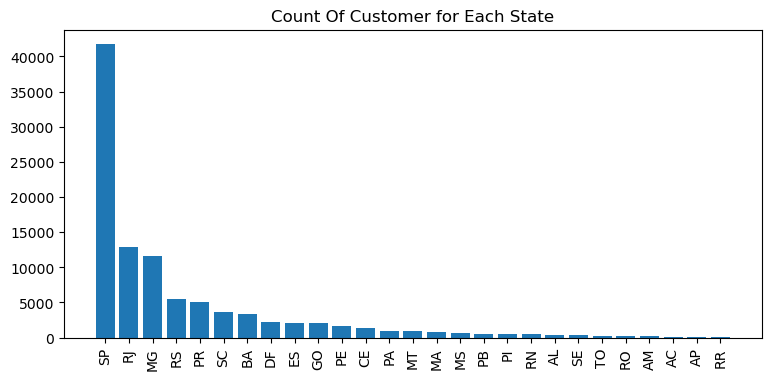

In [34]:
query = """
        select customer_state,count(customer_id) 
        from customers group by customer_state
        """

cur.execute(query)
data5 = cur.fetchall()
data5
df = pd.DataFrame(data5,columns =["State","Customer_Count"])
df = df.sort_values(by = "Customer_Count",ascending=False)


plt.figure(figsize = (9,4))
plt.bar(df["State"],df["Customer_Count"])
plt.xticks(rotation = 90)
plt.title('Count Of Customer for Each State')
plt.show()

###  Calculate the number of orders per month in 2018.

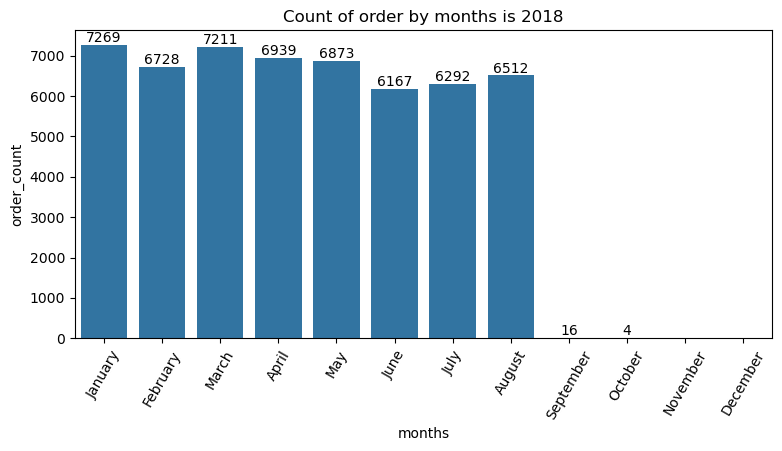

In [10]:
query = """
        select monthname(order_purchase_timestamp) months,count(order_id) order_count
        from orders where year(order_purchase_timestamp) = 2018
        group by months
        """
cur.execute(query)
data6 = cur.fetchall()
df = pd.DataFrame(data6,columns=["months","order_count"])
o = ["January" ,"February","March","April","May","June","July","August","September","October","November","December"]

plt.figure(figsize=[9,4])
ax = sns.barplot(x = df["months"],y = df["order_count"],data = df,order = o)
plt.xticks(rotation=60)
ax.bar_label(ax.containers[0])
plt.title("Count of order by months is 2018")
plt.show()

###  Find the average number of products per order, grouped by customer city.

In [11]:
query = """
         with count_per_order as (
         select orders.order_id,orders.customer_id,count(orders_items.order_id) as order_count
         from orders join orders_items 
         on orders.order_id = orders_items.order_id 
         group by orders.order_id,orders.customer_id)

         select customers.customer_city, round(avg(count_per_order.order_count),2)average_orders
         from customers join count_per_order
         on customers.customer_id = count_per_order.customer_id
         group by customers.customer_city order by average_orders desc
        """

cur.execute(query)
data7 = cur.fetchall()
df = pd.DataFrame(data7,columns=["Customer_city","Average"])
df
# plt.bar(df["Customer_city"],df["Average"])


,Customer_city,Average
0,padre carvalho,7.00
1,celso ramos,6.50
2,candido godoi,6.00
3,datas,6.00
4,matias olimpio,5.00
...,...,...
4105,sebastiao leal,1.00
4106,morro agudo de goias,1.00
4107,santa filomena,1.00
4108,guamiranga,1.00


###  Calculate the percentage of total revenue contributed by each product category.

In [12]:
query = """
        select upper(products.product_category) category,
        round((sum(payments.payment_value)/(select sum(payment_value)from payments))*100,2)as sales 
        from products join orders_items
        on products.product_id = orders_items.product_id
        join payments
        on payments.order_id = orders_items.order_id
        group by category order by sales desc
"""
cur.execute(query)
data8 = cur.fetchall()
df = pd.DataFrame(data8,columns=["Category","Sales"])
df

,Category,Sales
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
...,...,...
69,HOUSE COMFORT 2,0.01
70,CDS MUSIC DVDS,0.01
71,PC GAMER,0.01
72,FASHION CHILDREN'S CLOTHING,0.00


###  Identify the correlation between product price and the number of times a product has been purchased.

In [13]:
query = """
       select products.product_category,
       count(orders_items.product_id),
       round(avg(orders_items.price),2)
       from products join orders_items
       on products.product_id = orders_items.product_id
       group by products.product_category
       """

cur.execute(query)
data9 = cur.fetchall()
df = pd.DataFrame(data9,columns=["Category","Order_count","Price"])
df


,Category,Order_count,Price
0,HEALTH BEAUTY,9670,130.16
1,sport leisure,8641,114.34
2,Cool Stuff,3796,167.36
3,computer accessories,7827,116.51
4,Watches present,5991,201.14
...,...,...,...
69,flowers,33,33.64
70,Kitchen portable and food coach,15,264.57
71,House Comfort 2,30,25.34
72,CITTE AND UPHACK FURNITURE,38,114.95


In [14]:
query = """
        select * ,dense_rank() over (order by revenue desc) as rn from 
        (select orders_items.seller_id,sum(payments.payment_value)
        revenue from orders_items join payments
        on orders_items.order_id = payments.order_id
        group by orders_items.seller_id)as a
       """

cur.execute(query)
data10 = cur.fetchall()
df = pd.DataFrame(data10,columns = ["Seller_id","Revenue","Rank"])
df

,Seller_id,Revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.907302,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.039840,2
2,4a3ca9315b744ce9f8e9374361493884,301245.269765,3
3,1f50f920176fa81dab994f9023523100,290253.420128,4
4,53243585a1d6dc2643021fd1853d8905,284903.080498,5
...,...,...,...
3090,ad14615bdd492b01b0d97922e87cb87f,19.209999,3082
3091,702835e4b785b67a084280efca355756,18.559999,3083
3092,4965a7002cca77301c82d3f91b82e1a9,16.360001,3084
3093,77128dec4bec4878c37ab7d6169d6f26,15.220000,3085


###  Calculate the moving average of order values for each customer over their order history.

In [15]:
query = """
        select customer_id,order_purchase_timestamp,payment,
        avg(payment) over (partition by customer_id order by order_purchase_timestamp
        rows between 2 preceding and current row)as mov_avg
        from
        (select orders.customer_id,orders.order_purchase_timestamp,
        payments.payment_value as payment
        from payments join orders 
        on payments.order_id = orders.order_id)as a
        """

cur.execute(query)
data11 = cur.fetchall()
df = pd.DataFrame(data11,columns = ["Customer_id","Purchase_timestamp","Payments","Moving_avg"])
df

,Customer_id,Purchase_timestamp,Payments,Moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


###  Calculate the cumulative sales per month for each year.

In [16]:
query ="""
        select years,months,payment,sum(payment)
        over(order by years,months) cumulative_sales from
        (select year(orders.order_purchase_timestamp)as years,
        month(orders.order_purchase_timestamp)as months,
        round(sum(payments.payment_value),2)as payment from orders join payments
        on orders.order_id = payments.order_id
        group by years,months order by years,months) as a 
       """

cur.execute(query)
data12 = cur.fetchall()
df = pd.DataFrame(data12,columns = ["Years","Months","Payments","Cumulative_sales"])
df

,Years,Months,Payments,Cumulative_sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


###  Calculate the year-over-year growth rate of total sales.

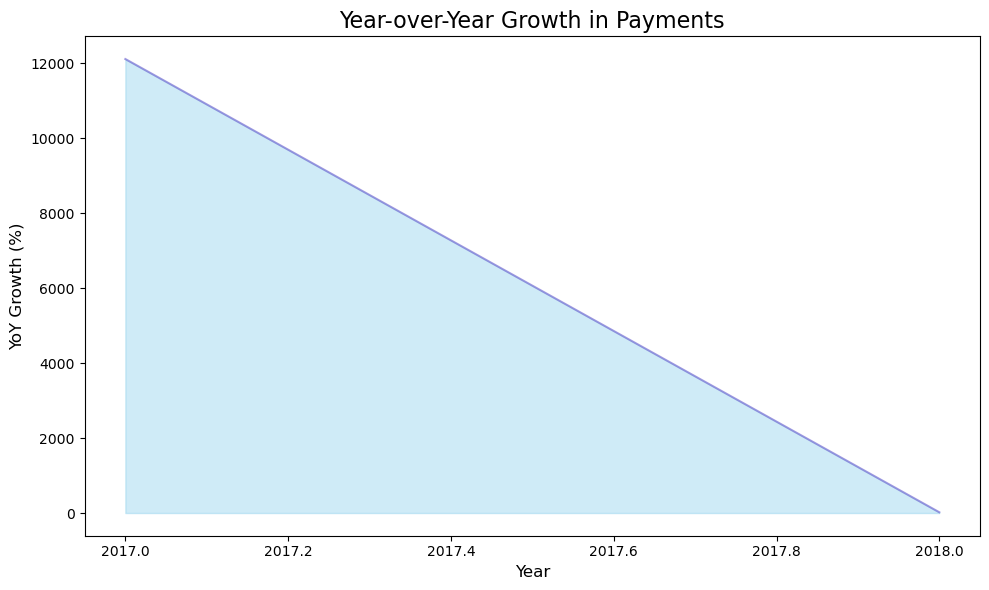

In [27]:
query = """
        with a as(select year(orders.order_purchase_timestamp)as years,
        round(sum(payments.payment_value),2)as payment from orders join payments
        on orders.order_id = payments.order_id
        group by years order by years)
        
        select years,((payment-lag(payment,1) over(order by years))/
        lag(payment,1) over(order by years))*100  from a
        """

cur.execute(query)
data13 = cur.fetchall()
df = pd.DataFrame(data13,columns = ["Years","Yoy%growth"])




# Create an area plot
plt.figure(figsize=(10, 6))
plt.fill_between(df['Years'], df['Yoy%growth'], color='skyblue', alpha=0.4)
plt.plot(df['Years'], df['Yoy%growth'], color='Slateblue', alpha=0.6)

# Set title and labels
plt.title('Year-over-Year Growth in Payments', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('YoY Growth (%)', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()



### Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [18]:
query = """
       with a as(select customers.customer_id,
       min(orders.order_purchase_timestamp)first_order
       from customers join orders
       on customers.customer_id = orders.customer_id
       group by customers.customer_id),

       b as (select a.customer_id,
       count(distinct orders.order_purchase_timestamp) next_order
       from a join orders 
       on orders.customer_id = a.customer_id
       and orders.order_purchase_timestamp > first_order
       and orders.order_purchase_timestamp <
       date_add(first_order,interval 6 month)
       group by a.customer_id)

       select 100 * (count(distinct a.customer_id)/count(distinct b.customer_id))
       from a left join b
       on a.customer_id = b.customer_id
        """

cur.execute(query)
data14 = cur.fetchall()
data14

[(None,)]

###  Identify the top 3 customers who spent the most money in each year.

<Figure size 1200x600 with 0 Axes>

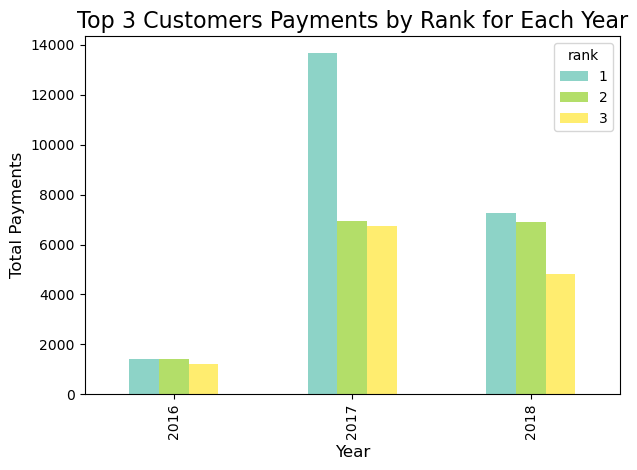

In [32]:
query = """
        select years,customer_id,payment,d_rank
        from
        (select year(orders.order_purchase_timestamp) years,
        orders.customer_id,
        sum(payments.payment_value) payment,
        dense_rank() over (partition by year(orders.order_purchase_timestamp)
        order by sum(payments.payment_value)desc)d_rank
        from orders join payments
        on payments.order_id = orders.order_id
        group by year(orders.order_purchase_timestamp),
        orders.customer_id) as a
        where d_rank <= 3
        """

cur.execute(query)
data15 = cur.fetchall()
df = pd.DataFrame(data15,columns=["Years","Id","Payments","rank"])


df_pivot = df.pivot_table(index='Years', columns='rank', values='Payments', aggfunc='sum')

# Create a grouped bar plot
plt.figure(figsize=(12, 6))
df_pivot.plot(kind='bar', stacked=False, colormap='Set3')

# Set title and labels
plt.title('Top 3 Customers Payments by Rank for Each Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Payments', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

